# Optimization of Barcelona's new subway line

### Final project - IBM Data Science Professional Certificate
### Author: Laia Alcaraz

Import libraries

In [37]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import preprocessing
from sklearn.cluster import KMeans
from math import sin, cos, sqrt, atan2, radians
#!pip install folium 
import folium
import matplotlib.pyplot as plt

## Setting the data

Create a Pandas dataframe with the name and the coordinates (latitude and longitude) of the stops which are still in construction and will be optimized, and a second dataframe for the stops that have already been built

In [38]:
df_coordstops = pd.DataFrame(columns=["Stop", "Latitude", "Longitude"], 
                        data=[["Campus Nord", 41.3882, 2.11539],
                              ["Manuel Girona", 41.3909, 2.123337], 
                              ["Prat de la Riba", 41.3934, 2.12886],
                              ["Mandri", 41.4052, 2.13134], 
                              ["Muntanya", 41.4097, 2.15494], 
                              ["Sanllehy", 41.41386944, 2.16095278],
                              ["Maragall", 41.425616666667, 2.1760861111111]])

df_coordfixedstops = pd.DataFrame(columns=["Stop", "Latitude", "Longitude"], 
                                  data=[["Zona Universitària", 41.384444444444, 2.112],
                                        ["El Putxet", 41.405819444444, 2.139],
                                        ["Sarrià", 41.398611, 2.125278],
                                        ["El Putxet", 41.405819444444, 2.139],
                                        ["Lesseps", 41.40611111, 2.14944444],
                                        ["Guinardó", 41.416041666667, 2.1743638888889],
                                        ["La Sagrera", 41.4225, 2.186944]])

In [39]:
print("Stops to be optimized: \n")
print(df_coordstops, "\n")
print("Built stops: \n")
print(df_coordfixedstops)

Stops to be optimized: 

              Stop   Latitude  Longitude
0      Campus Nord  41.388200   2.115390
1    Manuel Girona  41.390900   2.123337
2  Prat de la Riba  41.393400   2.128860
3           Mandri  41.405200   2.131340
4         Muntanya  41.409700   2.154940
5         Sanllehy  41.413869   2.160953
6         Maragall  41.425617   2.176086 

Built stops: 

                 Stop   Latitude  Longitude
0  Zona Universitària  41.384444   2.112000
1           El Putxet  41.405819   2.139000
2              Sarrià  41.398611   2.125278
3           El Putxet  41.405819   2.139000
4             Lesseps  41.406111   2.149444
5            Guinardó  41.416042   2.174364
6          La Sagrera  41.422500   2.186944


Credentials for the Foursquare API

In [40]:
CLIENT_ID = 'M1RHHLPPV1SUJ1T1GSBNPO03ZCC1NAZZ3ZM0V3TZXYIVAGWZ' 
CLIENT_SECRET = '0TM2RDLHYRADMIYQH2WTP4IHZ3YHTDXR1HPIMV0JOQEJM52F' 
ACCESS_TOKEN = 'F0LDLCDBVOWVEHGKTXWTE04QM515NZGIZK1VEJKSSAJMKSPY' 
VERSION = '20180604'
LIMIT = 100 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M1RHHLPPV1SUJ1T1GSBNPO03ZCC1NAZZ3ZM0V3TZXYIVAGWZ
CLIENT_SECRET:0TM2RDLHYRADMIYQH2WTP4IHZ3YHTDXR1HPIMV0JOQEJM52F


Function to get venues from Foursquare

In [41]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # Store the venues in a Pandas dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Stop', 
                  'Stop Latitude', 
                  'Stop Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

For each subway stop that has to be optimized, find out the top 100 venues that are within a radius of 500 m 

In [42]:
# Radius
r = 500

# Store the venues in a Pandas Dataframe 
df_bcn_venues = getNearbyVenues(names = df_coordstops['Stop'], latitudes = df_coordstops['Latitude'], longitudes = df_coordstops['Longitude'], radius = r)

df_bcn_venues.head()

,Stop,Stop Latitude,Stop Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Campus Nord,41.3882,2.11539,Palau Reial de Pedralbes (Palacio Real de Pedr...,41.388429,2.117046,Palace
1,Campus Nord,41.3882,2.11539,Jardins del Palau de Pedralbes (Jardines del P...,41.387298,2.117786,Garden
2,Campus Nord,41.3882,2.11539,Restaurante Tritón,41.386673,2.112519,Spanish Restaurant
3,Campus Nord,41.3882,2.11539,Frankfurt's Pedralbes,41.387089,2.112594,Hot Dog Joint
4,Campus Nord,41.3882,2.11539,Al Taglio,41.387258,2.112877,Pizza Place


## Data cleaning

Let's investigate the venues to find out more information about them

Text(0, 0.5, '# venues')

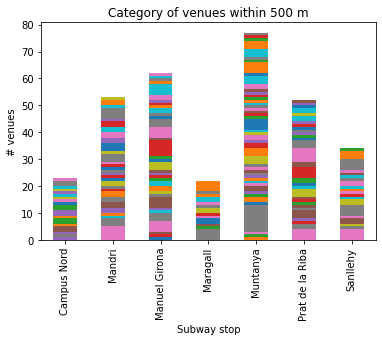

In [43]:
plt_venuescat = df_bcn_venues.groupby(["Stop", "Venue Category"]).size().unstack().plot(kind = "bar", stacked = True, legend = False)
plt_venuescat.set_title("Category of venues within 500 m")
plt_venuescat.set_xlabel("Subway stop")
plt_venuescat.set_ylabel("# venues")

The plot above shows there are too many venue categories, so let's define a function to help us cleaning them

In [44]:
def replace_strings(df, strings_before, string_after):

    for s in strings_before:
        df = df.str.replace(s, string_after)

    return df

Let's group the venues more general categories

In [45]:
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Restaurant.*", ".*Bar.*", ".*Pub.*", ".*Café.*", ".*Brewery.*", ".*Diner", ".*Bistro.*", ".*Bodega.*", ".*Hotel.*"], "Hotel & Restaurant")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Store.*", ".*Shop.*", ".*Supermarket.*", ".*Plaza.*", ".*Bakery.*", ".*Market.*"], "Shopping")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Sport.*", ".*Gym.*", ".*Fitness.*", ".*Stadium.*", ".*Court.*"], "Sport")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Disco.*", ".*Dance.*", ".*Night.*", ".*Club.*"], "Nightlife")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Gallery.*", ".*Museum*", ".*Art.*", ".*Palace.*", ".*Cinema.*", ".*Theater.*", ".*Church.*", ".*Park.*", ".*Garden.*"], "Culture & nature")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*College.*", ".*University.*", ".*School.*"], "Education")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Hospital.*", ".*Doctor.*", ".*Pharmacy.*"], "Health")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Station.*", ".*Garage.*", ".*Gas.*"], "Transportation")

Take a look at the venue category after cleaning the data

In [46]:
df_bcn_venues.groupby(["Venue Category"]).count()

,Stop,Stop Latitude,Stop Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
BBQ Joint,1,1,1,1,1,1
Bookstore,1,1,1,1,1,1
Breakfast Spot,3,3,3,3,3,3
Building,1,1,1,1,1,1
Burger Joint,6,6,6,6,6,6
Coworking Space,1,1,1,1,1,1
Culture & nature,18,18,18,18,18,18
Design Studio,1,1,1,1,1,1
Education,2,2,2,2,2,2


It can be seen that some venues didn't match the filtering criteria that was applied before, so a second cleaning is done to group the remaining venues

In [47]:
df_bcn_venues["Venue Category"] = df_bcn_venues["Venue Category"].str.replace("Bookstore", "Shopping")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Pizza.*", ".*Burger.*", ".*BBQ.*", ".*Breakfast.*", ".*Snack.*", ".*Deli", ".*Hot Dog.*", ".*Sandwich.*", ".*Salad.*"], "Hotel & Restaurant")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Pool.*", ".*Soccer.*", ".*Playground.*"], "Sport")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Building.*", ".*Historic Site.*", "Scenic Lookout", "Mountain"], "Culture & nature")
df_bcn_venues["Venue Category"] = replace_strings(df_bcn_venues["Venue Category"], [".*Space.*", "Multiplex"], "Others")

And now, the distribution of the venue's category is plotted again

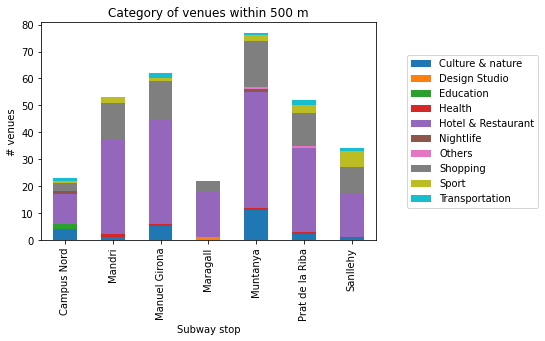

In [48]:
plt_venuescat_cleaned = df_bcn_venues.groupby(["Stop", "Venue Category"]).size().unstack().plot(kind = "bar", stacked = True)
plt_venuescat_cleaned.set_title("Category of venues within 500 m")
plt_venuescat_cleaned.set_xlabel("Subway stop")
plt_venuescat_cleaned.set_ylabel("# venues")
plt_venuescat_cleaned.legend(loc='right', bbox_to_anchor=(1.5, 0.5))

## Standard K-Means Clustering to optimize the stop's coordinates

Create a Pandas dataframe which will contain the result of applying K-Means 

In [49]:
df_bcn_venues_optim = df_bcn_venues.copy()
df_bcn_venues_optim.insert(3, 'Cluster labels', 0)
df_bcn_venues_optim.insert(4,'Cluster center latitude', 0)
df_bcn_venues_optim.insert(5,'Cluster center longitude', 0)

Normalize the data in order to apply K-Means

In [50]:
bcn_venues_4clustering = df_bcn_venues[["Venue Latitude", "Venue Longitude"]].values
scal = preprocessing.StandardScaler().fit(bcn_venues_4clustering)
bcn_venues_4clustering = scal.transform(bcn_venues_4clustering)
df_bcn_venues_4clustering = pd.DataFrame(bcn_venues_4clustering).copy()

The K-Means algorithm is run 10 times in order to find the optimal number of clusters (k) according to the Elbow method

In [51]:
distortions = []
for k in range(1,10):
    # Model training
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_bcn_venues_4clustering)
    distortions.append(kmeans.inertia_)

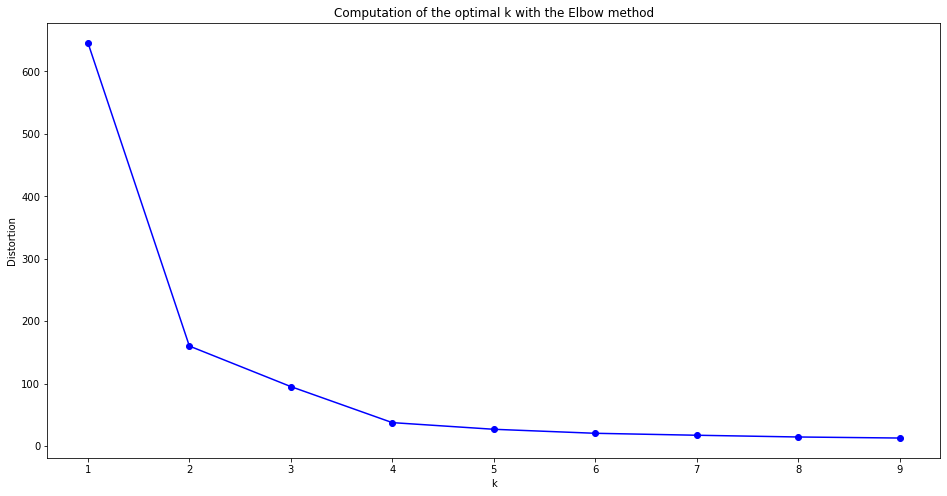

In [16]:
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bo-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Computation of the optimal k with the Elbow method')
plt.show()

And now, le'ts run k-Means again with the optimal number of clusters (k = 4)

In [52]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_bcn_venues_4clustering)

Apply an inverse transformation to the centroids of the clusters for an appropiate plot of the results

In [53]:
centroids = scal.inverse_transform(kmeans.cluster_centers_)

Fill in the dataframe with the output information from k-Means

In [54]:
for i in range(0, df_bcn_venues.shape[0]):
    cluster_label = kmeans.labels_[i]
    df_bcn_venues_optim.loc[i, 'Cluster center latitude'] = cluster_label
    df_bcn_venues_optim.loc[i, 'Cluster center latitude'] = centroids[cluster_label,0]
    df_bcn_venues_optim.loc[i, 'Cluster center longitude'] = centroids[cluster_label,1]

Function to compute the distance between two points (given in latitude and longitude coordinates)

In [55]:
def computeDistance(latitude1, longitude1, latitude2, longitude2):

    R = 6373000.0
    
    lat1 = radians(latitude1)
    lon1 = radians(longitude1)
    lat2 = radians(latitude2)
    lon2 = radians(longitude2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

For each subway stop, compute the distance between the input coordinates and the optimized one (from k-means)

In [56]:
coordstops = df_coordstops[["Latitude", "Longitude"]].values
error_matrix = np.zeros([coordstops.shape[0], centroids.shape[0]])

for i in range(0, error_matrix.shape[0]):
    for j in range(0, error_matrix.shape[1]):
        error_matrix[i,j] = computeDistance(coordstops[i,0], coordstops[i,1], centroids[j,0], centroids[j,1])
    print("Distance between planned coordinates and optimized coordinates for the subway stop ", df_coordstops.loc[i, "Stop"], ": ", format(min(error_matrix[i,:]), ".2f"), "m")


Distance between planned coordinates and optimized coordinates for the subway stop  Campus Nord :  789.53 m
Distance between planned coordinates and optimized coordinates for the subway stop  Manuel Girona :  64.72 m
Distance between planned coordinates and optimized coordinates for the subway stop  Prat de la Riba :  475.16 m
Distance between planned coordinates and optimized coordinates for the subway stop  Mandri :  204.85 m
Distance between planned coordinates and optimized coordinates for the subway stop  Muntanya :  231.64 m
Distance between planned coordinates and optimized coordinates for the subway stop  Sanllehy :  475.69 m
Distance between planned coordinates and optimized coordinates for the subway stop  Maragall :  77.26 m


Plot the results

Red -> Built stops

Blue -> Original position of the stops to be optimized

Yellow -> Optimization of the stop with standard k-means

Green -> Venues

In [57]:
# create map

address = "Barcelona, Spain"

geolocator = Nominatim(user_agent="bcn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, stop in zip(df_coordstops["Latitude"], df_coordstops["Longitude"], df_coordstops["Stop"]):
    label = '{}'.format(stop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters) 

 #add markers to map (fixed stops)   
for lat, lng, stop in zip(df_coordfixedstops["Latitude"], df_coordfixedstops["Longitude"], df_coordfixedstops["Stop"]):
    label = '{}'.format(stop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)                  
        
for lat, lng, stop in zip(df_bcn_venues["Venue Latitude"], df_bcn_venues["Venue Longitude"], df_bcn_venues["Venue"]):
    label = '{}'.format(stop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)         
            
        
for lat, lon, stop, cluster in zip(df_bcn_venues_optim['Cluster center latitude'], df_bcn_venues_optim['Cluster center longitude'], df_bcn_venues_optim['Stop'], df_bcn_venues_optim['Cluster labels']):
    label = folium.Popup(str(stop) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='black',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Weighted K-Means Clustering to optimize the stop's coordinates

It has already been seen that distribution of the venues around each bus stop are quite different, so let's assign weights to the different venues categories to give more importance to some of them when running k-means (e.g., a university or a hospital should be more important than a supermarket)

Definition of the dataframe which will also contain the weights

In [58]:
df_bcn_venues_woptim = df_bcn_venues.copy()
df_bcn_venues_woptim.insert(3, 'Cluster labels', 0)
df_bcn_venues_woptim.insert(4,'Cluster center latitude', 0)
df_bcn_venues_woptim.insert(5,'Cluster center longitude', 0)
df_bcn_venues_woptim.insert(10,"Venue Weight", 1)

And assign weights to the different venues

In [59]:
for i in range(0, df_bcn_venues_woptim["Venue Category"].shape[0]):
    cat =  df_bcn_venues_woptim.loc[i, "Venue Category"]

    if cat == "Health" or cat == "Education" or cat == "Transportation":
        df_bcn_venues_woptim.loc[i,"Venue Weight"] = 10
    elif cat == "Culture & nature" or cat == "Culture & nature":
        df_bcn_venues_woptim.loc[i, "Venue Weight"] = 2.5

Normalize the data

In [60]:
df_bcn_venues_4wclustering = pd.DataFrame(bcn_venues_4clustering)

wdistortions = []
for w_k in range(1,10):
    # Model training
    wkmeans = KMeans(n_clusters=w_k, random_state=0).fit(df_bcn_venues_4wclustering, sample_weight = df_bcn_venues_woptim["Venue Weight"])
    wdistortions.append(wkmeans.inertia_)

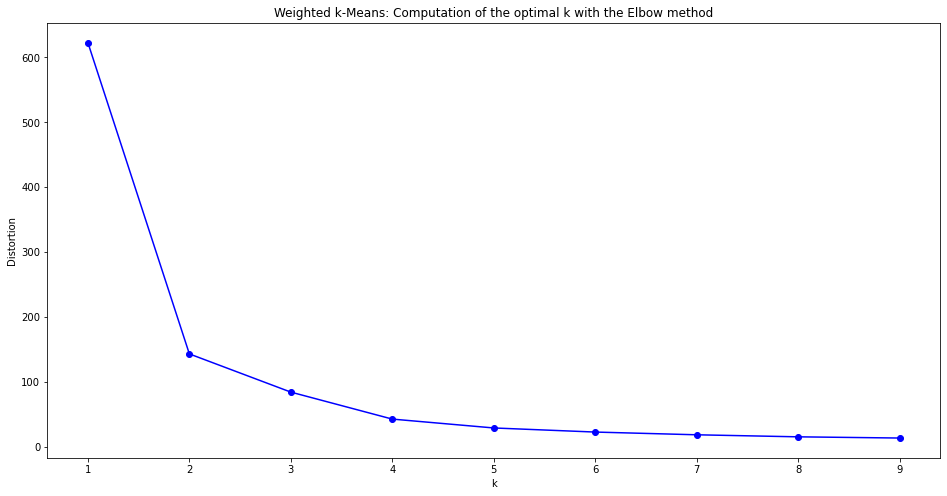

In [61]:
plt.figure(figsize=(16,8))
plt.plot(range(1,10), wdistortions, 'bo-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Weighted k-Means: Computation of the optimal k with the Elbow method')
plt.show()

Repeat the steps done for the standard k-means algorithm

In [62]:
wkmeans = KMeans(n_clusters=5, random_state=0).fit(df_bcn_venues_4wclustering, sample_weight = df_bcn_venues_woptim["Venue Weight"])
wcentroids = scal.inverse_transform(wkmeans.cluster_centers_)
for i in range(0, df_bcn_venues.shape[0]):
    wcluster_label = wkmeans.labels_[i]
    df_bcn_venues_woptim.loc[i, 'Cluster center latitude'] = wcluster_label
    df_bcn_venues_woptim.loc[i, 'Cluster center latitude'] = wcentroids[wcluster_label,0]
    df_bcn_venues_woptim.loc[i, 'Cluster center longitude'] = wcentroids[wcluster_label,1]

In [63]:
werror_matrix = np.zeros([coordstops.shape[0], wcentroids.shape[0]])

for i in range(0, werror_matrix.shape[0]):
    for j in range(0, werror_matrix.shape[1]):
        werror_matrix[i,j] = computeDistance(coordstops[i,0], coordstops[i,1], wcentroids[j,0], wcentroids[j,1])
    print("Distance between planned coordinates and optimized coordinates for the subway stop ", df_coordstops.loc[i, "Stop"], ": ", format(min(werror_matrix[i,:]), ".2f"), "m")

Distance between planned coordinates and optimized coordinates for the subway stop  Campus Nord :  338.87 m
Distance between planned coordinates and optimized coordinates for the subway stop  Manuel Girona :  408.46 m
Distance between planned coordinates and optimized coordinates for the subway stop  Prat de la Riba :  143.58 m
Distance between planned coordinates and optimized coordinates for the subway stop  Mandri :  200.08 m
Distance between planned coordinates and optimized coordinates for the subway stop  Muntanya :  211.96 m
Distance between planned coordinates and optimized coordinates for the subway stop  Sanllehy :  489.84 m
Distance between planned coordinates and optimized coordinates for the subway stop  Maragall :  77.26 m


Final plot

Red -> Built stops

Blue -> Original position of the stops to be optimized

Yellow -> Optimization of the stop with standard k-means

White -> Optimization of the stop with weighted k-means

Green -> Venues

In [64]:
# create map

address = "Barcelona, Spain"

geolocator = Nominatim(user_agent="bcn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_wclusters = folium.Map(location=[latitude, longitude], zoom_start=11)

#for lat, lng, stop in zip(df_coordstops["Latitude"], df_coordstops["Longitude"], df_coordstops["Stop"]):
#    label = '{}'.format(stop)
#    label = folium.Popup(label, parse_html=True)
#    folium.CircleMarker(
#        [lat, lng],
#        radius=5,
#        popup=label,
#        color='blue',
#        fill=True,
#        fill_color='blue',
#        fill_opacity=0.7,
#        parse_html=False).add_to(map_wclusters) 

 #add markers to map (fixed stops)   
for lat, lng, stop in zip(df_coordfixedstops["Latitude"], df_coordfixedstops["Longitude"], df_coordfixedstops["Stop"]):
    label = '{}'.format(stop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wclusters)                  
        
for lat, lng, stop in zip(df_bcn_venues["Venue Latitude"], df_bcn_venues["Venue Longitude"], df_bcn_venues["Venue"]):
    label = '{}'.format(stop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wclusters)         
            
        
for lat, lon, stop, cluster in zip(df_bcn_venues_optim['Cluster center latitude'], df_bcn_venues_optim['Cluster center longitude'], df_bcn_venues_optim['Stop'], df_bcn_venues_optim['Cluster labels']):
    label = folium.Popup(str(stop) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='black',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_wclusters)
    
for lat, lon, stop, cluster in zip(df_bcn_venues_woptim['Cluster center latitude'], df_bcn_venues_woptim['Cluster center longitude'], df_bcn_venues_woptim['Stop'], df_bcn_venues_woptim['Cluster labels']):
    label = folium.Popup(str(stop) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='black',
        fill=True,
        fill_color='white',
        fill_opacity=0.7).add_to(map_wclusters)    
       
map_wclusters